# Описание проекта

Федеральный оператор сотовой связи предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.<br>
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018-й год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.<br>

# Описание данных

Таблица users — информация о пользователях:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, значит, тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls — информация о звонках:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages — информация о сообщениях:
- id — уникальный номер звонка
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet — информация об интернет-сессиях:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs — информация о тарифах:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Описание тарифов
Тариф «Смарт»:<br>
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
- Сообщение — 3 рубля.
- 1 Гб интернет-трафика — 200 рублей.

Тариф «Ультра»:<br>
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- Минута разговора — 1 рубль;
- Сообщение — 1 рубль;
- 1 Гб интернет-трафика: 150 рублей.

# Шаг 1. Загрузка данных

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
sessions = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
# просмотр информации о загруженных таблицах
for i in [users, calls, sessions, messages, tariffs]:
    print(i.info())
    print('-------------------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), in

In [4]:
# просмотр информации о количестве дубликатов
for i in [users, calls, sessions, messages, tariffs]:
    print('Дубликатов:', i.duplicated().sum(), 'штук')
    print('-------------------------------------------------------------')

Дубликатов: 0 штук
-------------------------------------------------------------
Дубликатов: 0 штук
-------------------------------------------------------------
Дубликатов: 0 штук
-------------------------------------------------------------
Дубликатов: 0 штук
-------------------------------------------------------------
Дубликатов: 0 штук
-------------------------------------------------------------


Из информации выше видим, что у нас есть пропуски в столбце churn_date, но в данных к работе указано, что пропуски означают, что тарифом еще пользуются. Трогать этот столбец не будем.<br>
Столбцы с датами переводим в формат дат.<br>
В данных есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки. Однако в столбце duration датафрейма calls значения дробные. Необходимо округлить эти значение вверх до целого и перевести в целочисленный тип.<br>
Дубликатов нет.

# Шаг 2. Обработка данных

In [5]:
# перевод столбцов с датами в нужный формат
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
sessions['session_date'] = pd.to_datetime(sessions['session_date'])

In [6]:
# округление значений столбца duration с помощью np.ceil() и приведение типа к int
calls['duration'] = np.ceil(calls['duration']).astype(int)

In [7]:
# удаление столбца Unnamed: 0 из датафрейма internet.
sessions = sessions[['id', 'mb_used', 'session_date', 'user_id']]

In [8]:
# создание столбцов с месяцем в датафреймах calls, messages, sessions
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
sessions['month'] = pd.DatetimeIndex(sessions['session_date']).month

In [9]:
# подсчёт количества звонков для каждого пользователя по месяцам
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))

# подсчёт израсходованных минут для каждого пользователя по месяцам
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))

# подсчёт количества отправленных сообщений для каждого пользователя по месяцам
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))

# подсчёт потраченных мегабайт для каждого пользователя по месяцам
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})

In [10]:
# переименование столбца tariff_name на более простое tariff
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

# Шаг 3. Анализ данных и подсчёт выручки

Объединяем все посчитанные выше значения в один датафрейм `user_behavior`.<br>
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [11]:
# подсчет количества расторгнувших договор клиентов
print('Расторгли договор', users['churn_date'].count() / users['churn_date'].shape[0] * 100, '% клиентов из датасета')

Расторгли договор 7.6 % клиентов из датасета


In [12]:
# объединение таблиц
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

# подсчет количества пропусков 
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

In [13]:
# заполнение пропусков
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

In [14]:
# присоединение информации о тарифах
user_behavior = user_behavior.merge(tariffs, on='tariff')

In [15]:
# подсчет количества минут разговора, сообщений и мегабайт, превышающих включенные в тариф
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

In [16]:
# перевод превышающих тариф мегабайт в гигабайты и сохранение в столбец paid_gb
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

In [17]:
# подсчет выручки за минуты разговора, сообщения и интернет
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

In [18]:
# подсчет помесячной выручки с каждого пользователя, она будет храниться в столбце total_cost
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

In [19]:
# сохранение статистических метрик для каждой пары месяц-тариф в одной таблице 
stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

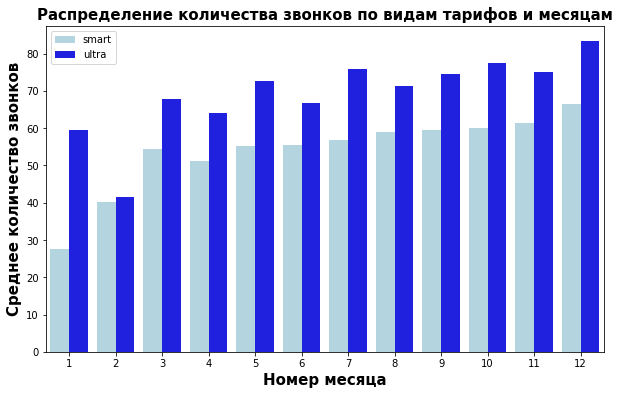

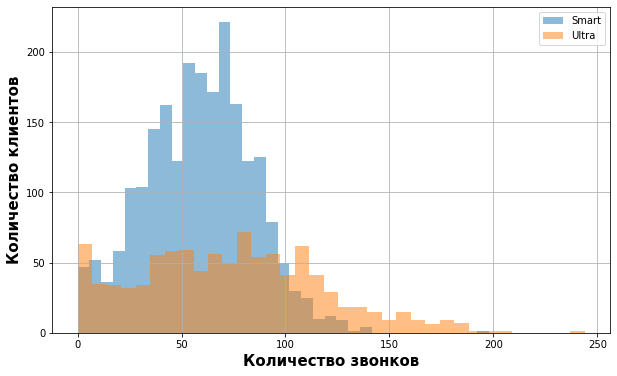

In [20]:
# построение графика распределения среднего количества звонков по видам тарифов и месяцам
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])
ax.set_title('Распределение количества звонков по видам тарифов и месяцам', fontsize=15, fontweight='bold')
ax.set_xlabel('Номер месяца', fontsize=15, fontweight='bold')
ax.set_ylabel('Среднее количество звонков', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'], loc='upper right', fontsize=10)
plt.xlabel('Количество звонков', fontsize=15, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

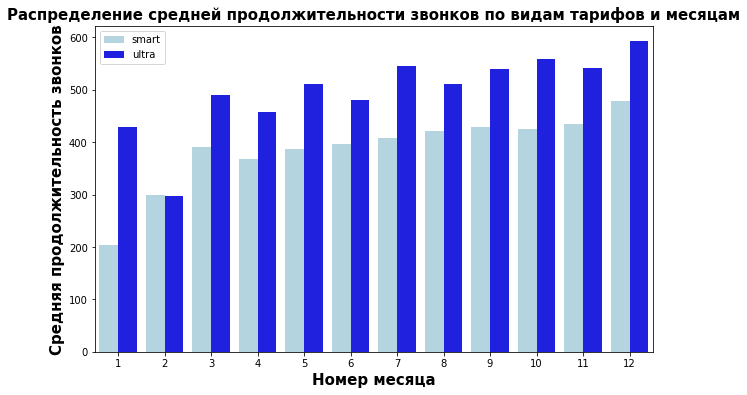

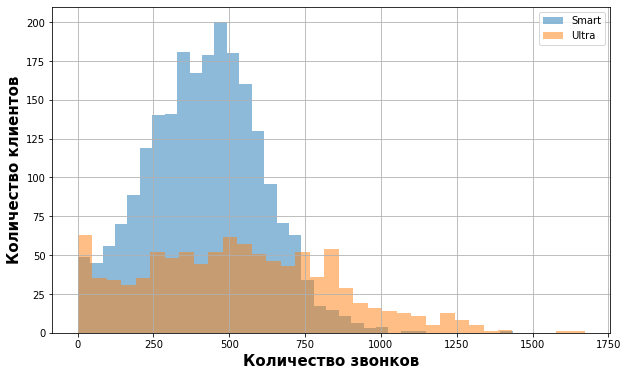

In [21]:
# построение графика распределения средней продолжительности звонков по видам тарифов и месяцам
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])
ax.set_title('Распределение средней продолжительности звонков по видам тарифов и месяцам', fontsize=15, fontweight='bold')
ax.set_xlabel('Номер месяца', fontsize=15, fontweight='bold')
ax.set_ylabel('Средняя продолжительность звонков', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
user_behavior.groupby('tariff')['minutes'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'], loc='upper right', fontsize=10)
plt.xlabel('Количество звонков', fontsize=15, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

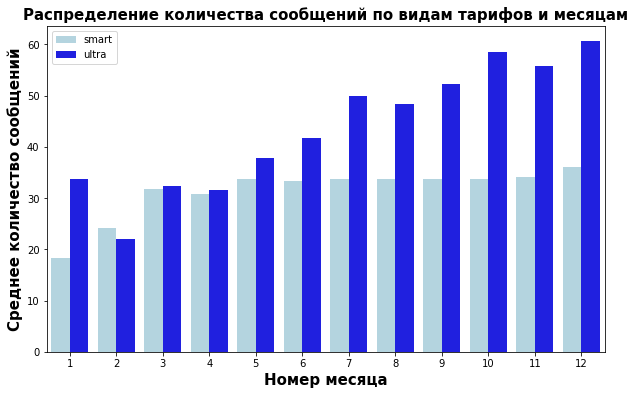

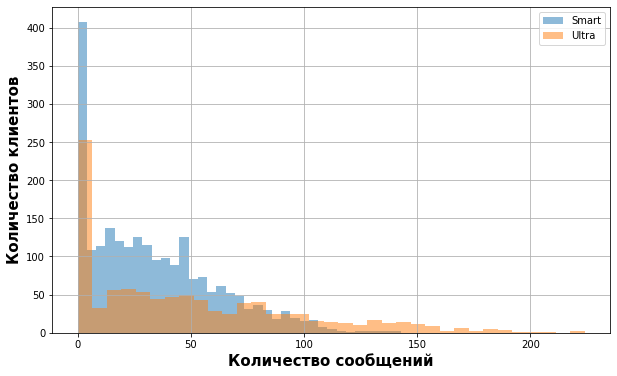

In [22]:
# построение графика распределения среднего количества сообщений по видам тарифов и месяцам
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])
ax.set_title('Распределение количества сообщений по видам тарифов и месяцам', fontsize=15, fontweight='bold')
ax.set_xlabel('Номер месяца', fontsize=15, fontweight='bold')
ax.set_ylabel('Среднее количество сообщений', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
user_behavior.groupby('tariff')['messages'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'], loc='upper right', fontsize=10)
plt.xlabel('Количество сообщений', fontsize=15, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную полодительную динамику.

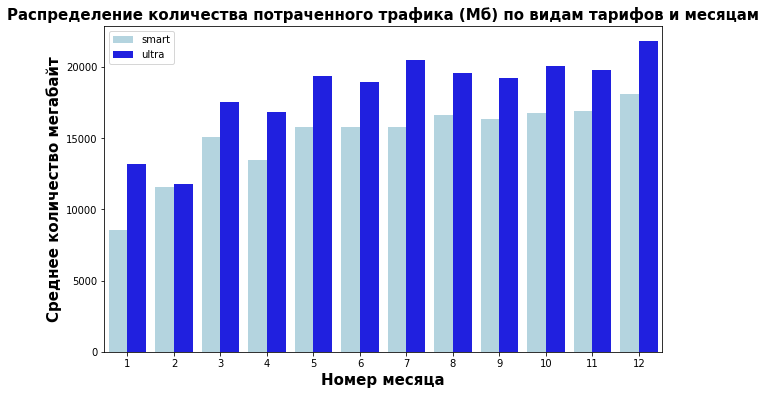

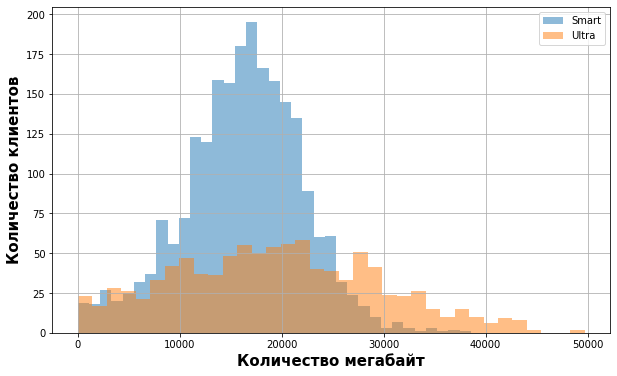

In [23]:
# построение графика распределения средней продолжительности звонков по видам тарифов и месяцам
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])
ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам', fontsize=15, fontweight='bold')
ax.set_xlabel('Номер месяца', fontsize=15, fontweight='bold')
ax.set_ylabel('Среднее количество мегабайт', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
user_behavior.groupby('tariff')['mb_used'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'], loc='upper right', fontsize=10)
plt.xlabel('Количество мегабайт', fontsize=15, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=15, fontweight='bold')
plt.grid()
plt.show()

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.

# Шаг 3. Проверка гипотез

### Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:

H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"<br>
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"<br>
alpha = 0.05

In [24]:
# results = вызов метода для проверки гипотезы
smart = user_behavior.loc[user_behavior.tariff == 'smart', 'total_cost']
ultra = user_behavior.loc[user_behavior.tariff == 'ultra', 'total_cost']
results = st.ttest_ind(smart, ultra, equal_var = False)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: # введите ваш код тут:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250
Отвергаем нулевую гипотезу


Для проверки гипотезы был выбран t-тест Стьюдента, т.к. мы имеем две независимые друг от друга генеральные совокупности. Но т.к. выборки у нас разного размера, то решено было добавить параметр equal_var = False <br>
Как видно из получившегося результата, можно отвергнуть нулевую гипотезу. Средняя выручка пользователей тарифов Ультра и Смарт - не равны, они отличаются.

### Проверка гипотезы: пользователи из Москвы приносят больше выручки, чем пользователи из других городов:

H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы <br>
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы <br>
alpha = 0.05

In [25]:
# results = вызов метода для проверки гипотезы
msk = user_behavior.loc[user_behavior.city == 'Москва', 'total_cost']
other = user_behavior.loc[user_behavior.city != 'Москва', 'total_cost']
results = st.ttest_ind(msk, other, equal_var = False)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: # введите ваш код тут:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Для проверки гипотезы был выбран t-тест Стьюдента, т.к. мы имеем две независимые друг от друга генеральные совокупности. Но т.к. выборки у нас разного размера, то решено было добавить параметр equal_var = False  <br>
Как видно из получившегося результата, мы не можем отвергнуть нулевую гипотезу. Следовательно клиенты из Москвы приносят в среднем столько же денег компании, сколько и пользователи из других регионов. 

# Шаг 4. Выводы

Были изучены предоставленные данные сотового оператора «Мегалайн» за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». <br>

В таблице messages посчитано количество используемых сообщений у каждого клиента за каждый месяц.<br>
В таблице sessions посчитано количество используемого интернет-трафика у каждого клиента за каждый месяц. Параментр переведен В гигабайты и округлен в большую сторону.<br>
В таблице calls посчитано количество используемых минут у каждого клиента за каждый месяц. Округлен в большую сторону.<br>

Посчитана помесячная выручка по кажому клиенту.<br>
Посчитано среднее, дисперсия и стандартное отклонение по количеству сообщений, использоного интернет трафика и количества минут у тарифов смарт и ультра.<br>

Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности.<br>
В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную полодительную динамику.<br>
Меньше всего пользователи использовали интернет в январе, феврале и апреле. <br>

В ходе исследования были проверены две гипотезы:<br>
- Гипотеза о различии средней выручки двух тарифов. Провели статистический тест с помощью t-теста Стьюдента. Получили статистически значимые различия двух средних.
- Гипотеза о различии средней выручки для пользователей из Москвы и для пользователей из других регионов. Статистически значимых различий между выручками пользователей нет.